In [30]:
%load_ext autoreload
%config Completer.use_jedi = False

In [31]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt


# Development Notebook for the FEMOL Project

In [407]:
"""
Benchmark problem uniform pressure on unit square plate
max defelxion = -0.004270
"""
Lx, Ly, n, m = 1, 1, 10, 10

mesh = FEMOL.mesh.rectangle_T6(Lx, Ly, n, m)
material = FEMOL.materials.isotropic_bending_benchmark()
t = 0.1

problem = FEMOL.FEM_Problem('displacement', 'plate', mesh)

problem.define_materials(material)
problem.define_tensors(t)
problem.add_fixed_domain(FEMOL.domains.inside_box([0, Lx], [[0, Ly]]), ddls=[2, 4])
problem.add_fixed_domain(FEMOL.domains.inside_box([[0, Lx]], [0, Ly]), ddls=[2, 3])

boundary_nodes = mesh.domain_nodes(FEMOL.domains.outside_box(0.01, 0.99, 0.01, 0.99))
all_nodes = np.arange(0, mesh.points.shape[0])

Force = -1

problem.add_forces([0, 0, Force, 0, 0, 0],
                   FEMOL.domains.inside_box([[0 + 0.01, Lx - 0.01]], [[0 + 0.01, Ly - 0.01]]))
problem.assemble('K')

mesh = problem.solve(verbose=False)
d_max = mesh.point_data['Uz'].min()
print(np.isclose(d_max, -0.004270, 1e-4))

False


In [408]:
d_max

-0.004595879796132791

In [406]:
Force

-0.81859410430839

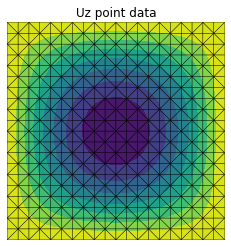

In [370]:
mesh.plot.point_data('Uz')

In [402]:
mesh.point_data['Uz'].shape

(1681,)

In [403]:
mesh.points.shape

(1681, 3)

In [398]:
nodes = mesh.domain_nodes(FEMOL.domains.inside_box([Ly/2], [[0, Lx]]))
pts_uz = mesh.point_data['Uz'][nodes]

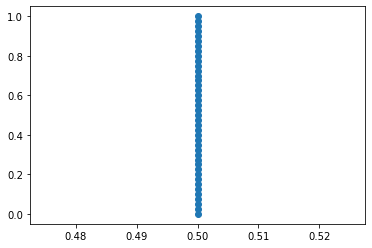

In [393]:
plt.scatter(*mesh.points[nodes].T[:2])

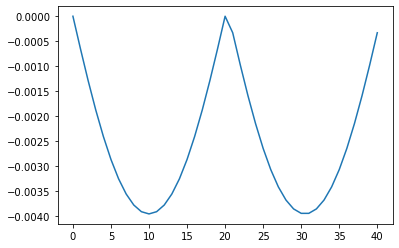

In [394]:
plt.plot(pts_uz)

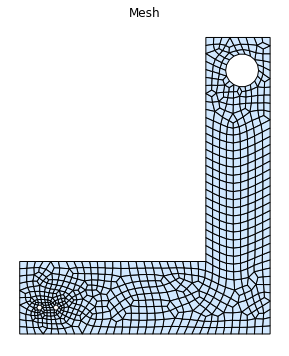

In [68]:
import FEMOL
import pygmsh

# Creating a mesh looking like the problem
with pygmsh.geo.Geometry() as geom:
    # Top circle
    circle = geom.add_circle([0.135, 0.160], 0.010, mesh_size=0.005, make_surface=False)
    # Bottom circles
    circle2 = geom.add_circle([0.012, 0.016], 0.0034 / 2, mesh_size=0.005, make_surface=False)
    circle3 = geom.add_circle([0.022, 0.016], 0.0034 / 2, mesh_size=0.005, make_surface=False)

    # main polygon
    poly = geom.add_polygon(
        [[0.0, 0.0],
         [0.152, 0.0],
         [0.152, 0.180],
         [0.113, 0.180],
         [0.113, 0.044],
         [0.0, 0.044], ],
        mesh_size=0.005,
        holes=[circle.curve_loop, circle2.curve_loop, circle3.curve_loop]
    )
    # Make it into quads
    geom.set_recombined_surfaces([poly.surface])
    # Create the meshio mesh
    mesh = geom.generate_mesh(dim=2)

# Transform into FEMOL mesh
mesh = FEMOL.Mesh(mesh.points, mesh.cells_dict)
mesh.display()

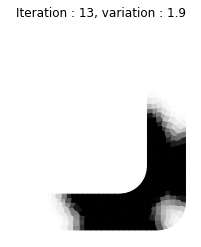

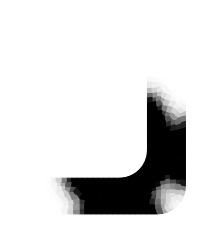

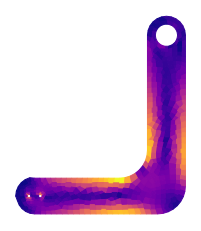

In [86]:
# Create a round L bracket mesh
mesh2 = FEMOL.misc.L_bracket_mesh2(0.005)

# Create a FEM Problem from the mesh (compute displacement with a plane stress model)
problem = FEMOL.FEM_Problem(mesh=mesh2, physics='displacement', model='plane')

# Define the problem material and part thickness
PLA = FEMOL.materials.IsotropicMaterial(100e2, 0.3, 1)
problem.define_materials(PLA)
problem.define_tensors(1)

# Add a force on the top circle nodes
top_circle = FEMOL.domains.inside_circle(*[0.135, 0.160], 0.0105)
problem.add_forces([-1000, -1000], top_circle)

# Fix the two bottom circles
bot_circle_1 = FEMOL.domains.inside_circle(*[0.012, 0.016], 0.0034/2 + 0.001)
bot_circle_2 = FEMOL.domains.inside_circle(*[0.022, 0.016], 0.0034/2 + 0.001)
problem.add_fixed_domain(bot_circle_1)
problem.add_fixed_domain(bot_circle_2)

# Plot the problem to see everything is alright
#problem.plot()

# Solve the FEM problem
mesh2 = problem.solve(verbose=False)
mesh2.stress_from_displacement(problem.C_A, N_dof=2)

mesh2.plot.cell_data('Sv', cmap='plasma')

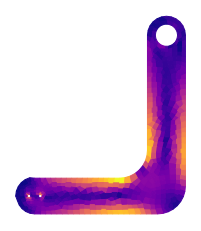

In [77]:
mesh.plot.cell_data('Sv', cmap='plasma')

In [ ]:
centers = []
for cell in mesh.cells['quad']:
    element = mesh.ElementClasses['quad'](mesh.points[cell])
    centers.append(element.center())

centers = [list(p) for p in centers]
centers = np.array(centers)

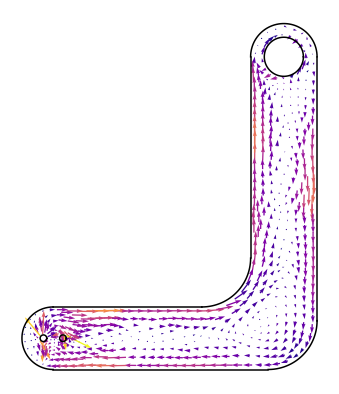

In [274]:
# Plot the constraints vector field
fig, ax = plt.subplots(figsize=(7, 7))
U = mesh.cell_data['Sx']['quad']
V = mesh.cell_data['Sy']['quad']
X = centers[:, 0]
Y = centers[:, 1]
C = mesh.cell_data['Sv']['quad']
ax.quiver(X, Y, U, V, [C], cmap='plasma', width=0.004)
ax.set_aspect('equal')
ax.set_axis_off()
FEMOL.misc.plot_L_outline2()

fig.savefig('stressquiver', dpi=250)


In [246]:
centers[:, 1].shape

(588,)

In [237]:
list(p)

[0.09981189585775042, 0.025520118862322336]

In [325]:
Smax = 32.938  # MPa
F = 10
Smax = 0

while Smax < 33e3:
    # Create a FEM Problem from the mesh (compute displacement with a plane stress model)
    problem = FEMOL.FEM_Problem(mesh=mesh, physics='displacement', model='plane')

    # Define the problem material and part thickness
    PLA = FEMOL.materials.IsotropicMaterial(807e6, 0.3, 1)
    problem.define_materials(PLA, PLA)
    problem.define_tensors(0.005, 0.005)

    # Add a force on the top circle nodes
    top_circle = FEMOL.domains.inside_circle(*[0.135, 0.160], 0.0105)
    problem.add_forces([-F, -F], top_circle)

    # Fix the two bottom circles
    bot_circle_1 = FEMOL.domains.inside_circle(*[0.012, 0.016], 0.0034/2 + 0.001)
    bot_circle_2 = FEMOL.domains.inside_circle(*[0.022, 0.016], 0.0034/2 + 0.001)
    problem.add_fixed_domain(bot_circle_1)
    problem.add_fixed_domain(bot_circle_2)

    # Plot the problem to see everything is alright
    #problem.plot()

    # Solve the FEM problem
    problem.assemble('K', X=mesh.cell_data['X'], p=1)
    mesh = problem.solve(verbose=False)
    mesh.stress_from_displacement(problem.C_A, N_dof=2)
    Smax = mesh.cell_data['Sv']['quad'].max()
    F *= 10

In [326]:
mesh.cell_data['Sv']['quad'].max()

54028.75121794515

In [333]:
mesh.point_data['Ux'].max()

0.011316651510710853

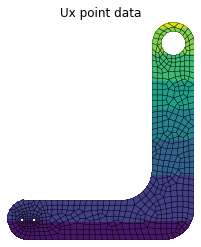

In [289]:
mesh.plot.point_data('Ux')

In [334]:
mesh = FEMOL.mesh.load_vtk('L3.vtk')

In [336]:
mesh.cell_data

{}